In [137]:
import numpy as np
import pandas as pd
from scipy import stats
from scipy.stats import qmc
import matplotlib.pyplot as plt

In [139]:
class SobolBrownianBridge:
    
    def __init__(self, S0: float, mu: float, sigma: float, T: float, n_steps: int, N_paths: int):

        self.S0 = S0
        self.mu = mu
        self.sigma = sigma
        self.T = T
        self.n_steps = n_steps
        self.N_paths = N_paths
        self.dt = T/n_steps

    def SobolNumber(self, dim: int, n_numbers: int):

        sampler = qmc.Sobol(d=dim, scramble = True)

        skip = min(128, 2**dim - 1)
        m = int(np.ceil(np.log2(n_numbers + skip)))

        sobol_numbers = sampler.random_base2(m=m)
        sobol_numbers = sobol_numbers[skip: skip + n_numbers]

        sobol_z = stats.norm.ppf(sobol_numbers)

        return sobol_z

    def BrownianBridge(self, sobolseq_z: np.ndarray):

        N_paths, n_steps = sobolseq_z.shape
        
        paths=np.zeros((N_paths, n_steps + 1))

        paths[:,-1] = np.sqrt(self.T) * sobolseq_z[:,0]

        level = int(np.ceil(np.log2(self.n_steps)))

        for L in range(1, level+1):
            step_size = 2**(level-L+1)

            seg_counter = 2**(L-1)-1

            for seg_No in range(0, seg_counter+1):

                left_idx = seg_No * step_size
                right_idx = (seg_No+1) * step_size
                mid_idx = left_idx + (step_size//2)

                if right_idx <= self.n_steps:

                    time_left = left_idx * self.dt
                    time_right = right_idx * self.dt
                    time_mid = mid_idx * self.dt

                    mean = (paths[:,left_idx] * (time_right - time_mid) + 
                            paths[:,right_idx] * (time_mid - time_left)) / (time_right - time_left)

                    var = (time_mid - time_left) * (time_right - time_mid) / (time_right - time_left)
                    std_dev = np.sqrt(var)

                    paths[:, mid_idx] = mean + std_dev * sobolseq_z[:, min(seg_No + 1, sobolseq_z.shape[1]-1)]

        return paths

    def pathsimulation(self):

        time_points = np.linspace(0, self.T, self.n_steps + 1)

        sobolseq_z = self.SobolNumber(dim = self.n_steps, n_numbers = self.N_paths)
        print(f"sobolseq_z shape: {sobolseq_z.shape}")
        
        BrownianBridgePaths = self.BrownianBridge(sobolseq_z)
        print(f"BrownianBridgePaths shape: {BrownianBridgePaths.shape}")
        
        drift = (self.mu - 0.5 * self.sigma**2) * time_points
        drift = drift.reshape(1,-1)
        print(f"drift shape: {drift.shape}")
        
        diffusion = self.sigma * BrownianBridgePaths
        print(f"diffusion shape: {diffusion.shape}")
        
        GBMpaths = self.S0 * np.exp(drift + diffusion)
        print(f"GBMpaths shape: {GBMpaths.shape}")

        return time_points, GBMpaths

#keep paths in rows


    def visulizationpaths(self, time_points, GBMpaths_f, n_display = 10):
        plt.figure(figsize=(20,12))
        for i in range(min(n_display, self.N_paths)):
            plt.plot(time_points, GBMpaths_f[i,:])
            
        plt.title("GBM Path Simulation using Brownian Bridge with Sobol")
        plt.xlabel('Time Steps')
        plt.ylabel('Index Level')
        plt.show()
        

        

In [141]:
S0=100
mu=0.05
sigma=0.2
T=1
N_paths=4096
n_steps=252

In [143]:
simulation01 = SobolBrownianBridge(S0, mu, sigma, T, N_paths, n_steps)
               
            

In [129]:
time_points, GBMpaths_f = simulation01.pathsimulation()

sobolseq_z shape: (252, 4096)
BrownianBridgePaths shape: (252, 4097)
drift shape: (1, 4097)
diffusion shape: (252, 4097)
GBMpaths shape: (252, 4097)


In [131]:
print(GBMpaths_f.shape)

(252, 4097)


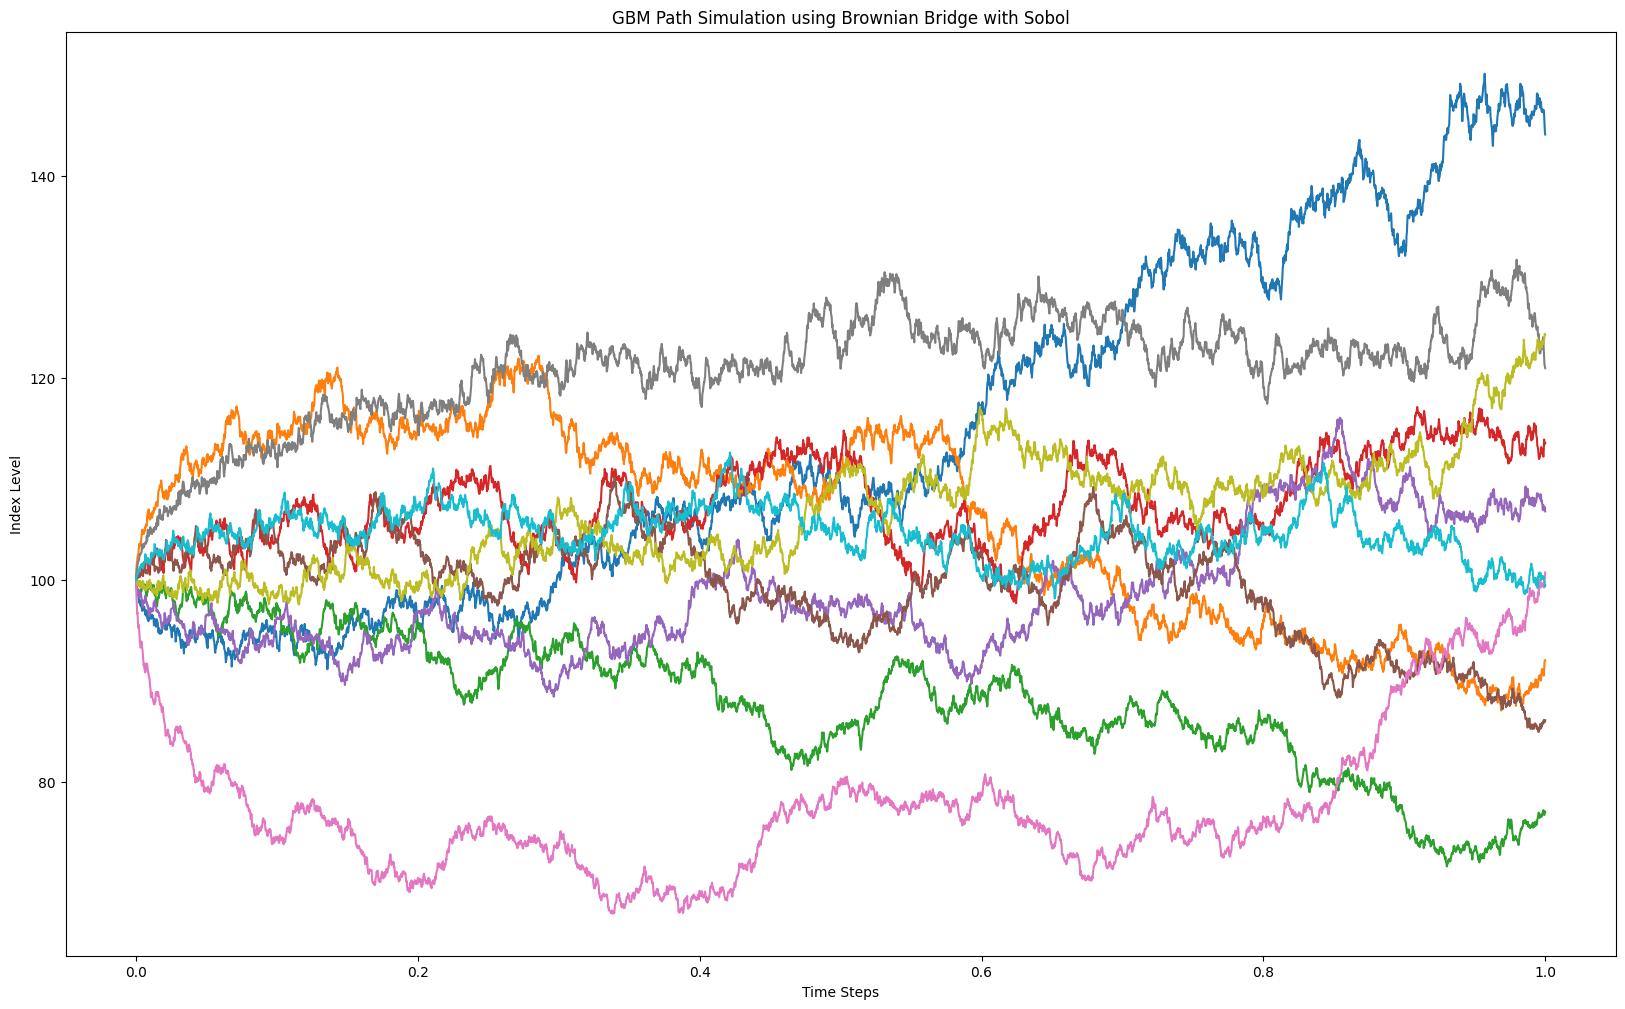

In [133]:
simulation01.visulizationpaths(time_points, GBMpaths_f)

sobolseq_z shape: (252, 4096)
BrownianBridgePaths shape: (252, 4097)
drift shape: (1, 4097)
diffusion shape: (252, 4097)
GBMpaths shape: (252, 4097)


(array([1., 1., 0., 0., 2., 0., 2., 0., 3., 2., 1., 3., 1., 2., 4., 4., 3.,
        2., 4., 4., 4., 5., 5., 4., 4., 6., 6., 5., 5., 6., 6., 6., 4., 6.,
        6., 5., 6., 6., 4., 7., 5., 4., 6., 4., 5., 4., 4., 5., 4., 5., 2.,
        3., 3., 3., 5., 3., 2., 2., 3., 2., 2., 3., 2., 2., 2., 2., 2., 0.,
        2., 0., 2., 1., 1., 0., 2., 0., 1., 2., 1., 0., 0., 1., 1., 0., 0.,
        0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1.]),
 array([ 61.43386208,  62.56853819,  63.7032143 ,  64.83789041,
         65.97256652,  67.10724263,  68.24191873,  69.37659484,
         70.51127095,  71.64594706,  72.78062317,  73.91529927,
         75.04997538,  76.18465149,  77.3193276 ,  78.45400371,
         79.58867981,  80.72335592,  81.85803203,  82.99270814,
         84.12738425,  85.26206036,  86.39673646,  87.53141257,
         88.66608868,  89.80076479,  90.9354409 ,  92.070117  ,
         93.20479311,  94.33946922,  95.47414533,  96.60882144,
         97.74349754,  98.87817365, 10

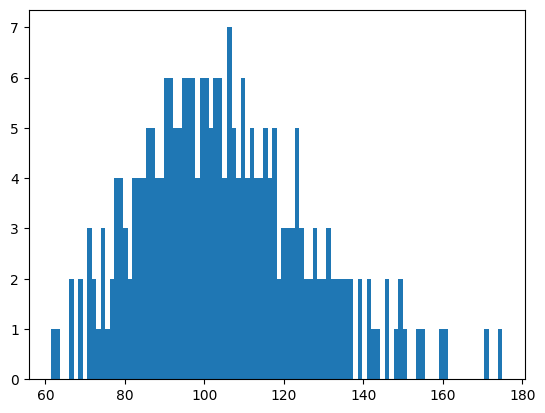

In [147]:
time_points, GBMpaths = simulation01.pathsimulation()
plt.hist(GBMpaths[:,-1],bins = 100)

sobolseq_z shape: (252, 4096)
BrownianBridgePaths shape: (252, 4097)
drift shape: (1, 4097)
diffusion shape: (252, 4097)
GBMpaths shape: (252, 4097)


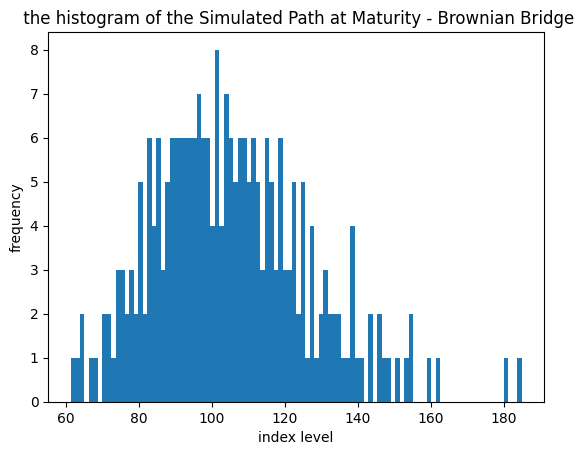

In [166]:
time_points, GBMpaths = simulation01.pathsimulation()
plt.hist(GBMpaths[:,-1],bins = 100)
plt.title(' the histogram of the Simulated Path at Maturity - Brownian Bridge')
plt.xlabel('index level')
plt.ylabel('frequency')
plt.show()

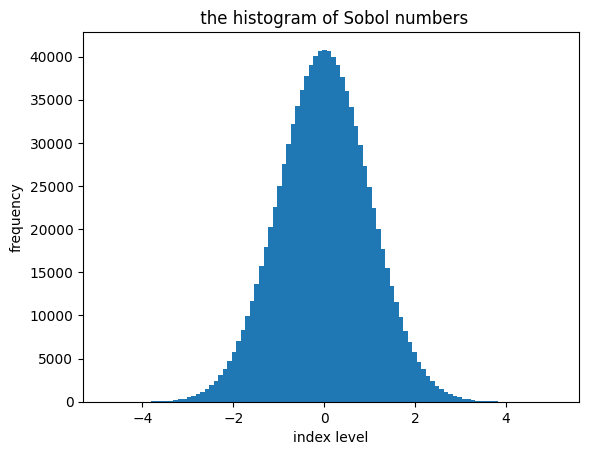

In [153]:
sobol_z = simulation01.SobolNumber(dim = n_steps, n_numbers = N_paths )
plt.hist(sobol_z.flatten(), bins= 100)
plt.title(' the histogram of Sobol numbers')
plt.xlabel('index level')
plt.ylabel('frequency')
plt.show()

In [159]:
sobol_z.mean(), sobol_z.std()

(2.6132861627827364e-06, 1.0000899454729617)